# 필요 package

In [1]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

import os
import warnings
warnings.filterwarnings(action='ignore')

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.width', 1000)

from selenium import webdriver as wd
import time
from bs4 import BeautifulSoup
import requests
import re

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# 크롤링 코드

In [2]:
browser = wd.Chrome("../../software/chromedriver.exe")
browser.get("https://www.airport.co.kr/jeju/extra/flightSchedule/flightDomesticList/layOut.do?cid=2015120718125215729&menuId=653")

element = browser.find_element_by_xpath('//*[@id="selType"]')
element.click()

element = browser.find_element_by_xpath('//*[@id="selType"]/option[2]')
element.click()

element = browser.find_element_by_xpath('//*[@id="findDate"]')
element.clear()
element.send_keys("2019-10-27")

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[2]/form/div/div[2]/button')
element.click()

air_head = []

element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/thead')

for i in range(1, 264):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[3]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
for i in range(1, 272):
    temp = []
    for j in range(1, 9):  
        element = browser.find_element_by_xpath('//*[@id="customer_container"]/div[4]/table/tbody[1]/tr[{0}]/td[{1}]'.format(i, j))
        temp.append(element.text)
    air_content.append(temp)
    
test = pd.DataFrame(data = air_content, columns = air_head)

test["제주 관련 시간"] = 0
test["제주 시간 관련"] = 0

for i in range(len(test)):
    if test["출발지"][i] == "제주":
        test["제주 관련 시간"][i] = test["출발시간"][i]
    else:
        test["제주 관련 시간"][i] = test["도착시간"][i]
        
test.drop("편명", axis = 1, inplace = True)

test.to_csv("../data/result_air.csv")

WebDriverException: Message: 'chromedriver.exe' executable needs to be in PATH. Please see https://sites.google.com/a/chromium.org/chromedriver/home


# 데이터 불러오기

In [24]:
# 데이터 불러오기
bus_df = pd.read_csv("bus_train_data.csv")
weather_df = pd.read_csv("jeju_weather.csv")
air_df = pd.read_csv("result_air.csv")

In [25]:
weather_df["date"] = "date"

In [26]:
for i in range(len(weather_df["date_group"])):
    weather_df["date"][i] = weather_df["date_group"][i].replace("일", "")
    weather_df["date"][i] = "2019-10-{0}".format(weather_df["date"][i])
    
weather_df = weather_df.rename(columns = {"time_group" : "now_arrive_time"})
weather_df = weather_df.drop(weather_df.columns[[0,2,5,7,8,9,10,11]],  axis = 1)

bus_weather_df = pd.merge(bus_df, weather_df)

In [27]:
temp = air_df.groupby(["날짜", "시간"]).count()
temp = pd.DataFrame(temp["항공사"].unstack())

data_list = []

for i in range(len(temp.index)):
    for j in range(len(temp.columns)):
        data_list.append([temp.index[i],temp.columns[j], temp.iloc[i][j]])
        
air_df = pd.DataFrame(data_list)

air_df.columns = ["date", "now_arrive_time", "count"]

df = pd.merge(bus_weather_df, air_df)

train = df

In [28]:
# 날짜 전처리
train['date_group']='weekday' #date_group 변수를 미리 생성

train.loc[ (train['date'] == '2019-10-19') | (train['date'] == '2019-10-20') | (train['date'] == '2019-10-26') | (train['date'] == '2019-10-27') ,['date_group'] ]= 'weekend' # 주말
train = pd.get_dummies(train,columns=['date_group'])

# 19, 20, 26, 27

In [29]:
# 강수량 전처리
train['rain']=0
train.loc[ (train['누적강수량(mm)']!=0) ,['rain'] ] = 1

In [30]:
# 시간 전처리
train['time_group']='group' #time_group 변수를 미리 생성

train.loc[ (train['now_arrive_time']>='05시') & (train['now_arrive_time']<='06시') ,['time_group'] ]= 'dawn' # 05~06시
train.loc[ (train['now_arrive_time']>='07시') & (train['now_arrive_time']<='08시') ,['time_group'] ]= 'morning' #07~08시
train.loc[ (train['now_arrive_time']>='09시') & (train['now_arrive_time']<='17시') ,['time_group'] ]= 'afternoon' #09~17시
train.loc[ (train['now_arrive_time']=='18시') ,['time_group'] ]= 'dinner' #18시
train.loc[ (train['now_arrive_time']>='19시') & (train['now_arrive_time']<='22시') ,['time_group'] ]= 'night' #09~17시

train = pd.get_dummies(train,columns=['time_group'])

In [31]:
# 풍속
w = pd.DataFrame(train['풍속(m/s)'].groupby([train['date'],train['now_arrive_time']]).mean())
train['wind'] = 0
train.loc[(train['풍속(m/s)'] > w.mean()[0]) ,['wind']] = 1

In [32]:
train = train.drop(train[train['next_arrive_time']>1000].index)

In [33]:
train = train.drop(train[["누적강수량(mm)", "풍속(m/s)"]], axis = "columns")

In [34]:
train

,id,date,route_id,vh_id,route_nm,now_latitude,now_longitude,now_station,now_arrive_time,distance,next_station,next_latitude,next_longitude,next_arrive_time,기온(°C),count,date_group_weekday,date_group_weekend,rain,time_group_afternoon,time_group_dawn,time_group_dinner,time_group_morning,time_group_night,wind
0,0,2019-10-15,405136001,7997025,360-1,33.456267,126.551750,제주대학교입구,06시,266.0,제대마을,33.457724,126.554014,24,15.526667,3,1,0,0,0,1,0,0,0,0
1,1,2019-10-15,405136001,7997025,360-1,33.457724,126.554014,제대마을,06시,333.0,제대아파트,33.458783,126.557353,36,15.526667,3,1,0,0,0,1,0,0,0,0
2,2,2019-10-15,405136001,7997025,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,40,15.526667,3,1,0,0,0,1,0,0,0,0
3,3,2019-10-15,405136001,7997025,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,42,15.526667,3,1,0,0,0,1,0,0,0,0
4,181,2019-10-15,405136001,7997034,360-1,33.484860,126.542928,제주여자중고등학교(아라방면),06시,578.0,남국원(아라방면),33.479705,126.543811,92,15.526667,3,1,0,0,0,1,0,0,0,0
5,182,2019-10-15,405136001,7997034,360-1,33.473655,126.545425,아라주공아파트,06시,244.0,인다마을,33.471450,126.545400,20,15.526667,3,1,0,0,0,1,0,0,0,0
6,183,2019-10-15,405136001,7997034,360-1,33.458783,126.557353,제대아파트,06시,415.0,제주대학교,33.459893,126.561624,36,15.526667,3,1,0,0,0,1,0,0,0,0
7,184,2019-10-15,405136001,7997034,360-1,33.479705,126.543811,남국원(아라방면),06시,578.0,제주여자중고등학교(아라방면),33.484860,126.542928,84,15.526667,3,1,0,0,0,1,0,0,0,0
8,539,2019-10-15,405136001,7997040,360-1,33.478867,126.483833,한라중학교/부영아파트,06시,417.0,대림2차아파트,33.478850,126.488350,158,15.526667,3,1,0,0,0,1,0,0,0,0
9,540,2019-10-15,405136001,7997040,360-1,33.478850,126.488350,대림2차아파트,06시,334.0,연동대림1차아파트,33.480700,126.489933,54,15.526667,3,1,0,0,0,1,0,0,0,0


In [35]:
train_x = train.drop(train[["id", "date","route_id", "vh_id", "route_nm", "now_latitude", "now_longitude", "now_station", "now_arrive_time", "next_station", "next_arrive_time", "next_latitude", "next_longitude"]], axis = "columns")
train_y = train.next_arrive_time

In [42]:
train_x

,distance,기온(°C),count,date_group_weekday,date_group_weekend,rain,time_group_afternoon,time_group_dawn,time_group_dinner,time_group_morning,time_group_night,wind
0,266.0,15.526667,3,1,0,0,0,1,0,0,0,0
1,333.0,15.526667,3,1,0,0,0,1,0,0,0,0
2,415.0,15.526667,3,1,0,0,0,1,0,0,0,0
3,578.0,15.526667,3,1,0,0,0,1,0,0,0,0
4,578.0,15.526667,3,1,0,0,0,1,0,0,0,0
5,244.0,15.526667,3,1,0,0,0,1,0,0,0,0
6,415.0,15.526667,3,1,0,0,0,1,0,0,0,0
7,578.0,15.526667,3,1,0,0,0,1,0,0,0,0
8,417.0,15.526667,3,1,0,0,0,1,0,0,0,0
9,334.0,15.526667,3,1,0,0,0,1,0,0,0,0


In [36]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y)

In [37]:
rf = RandomForestRegressor(random_state=1217)
rf.fit(X_train,y_train)
result = 0
predict = rf.predict(X_test)
print((mean_squared_error(predict, y_test))**0.5)

46.18892347180426


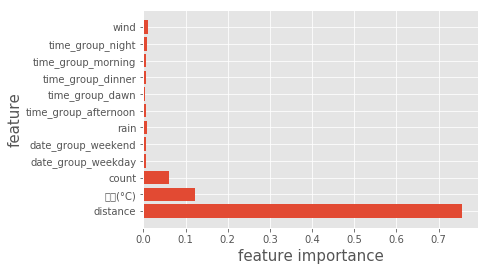

In [38]:
n_feature = train_x.shape[1] #주어진 변수들의 갯수를 구함
index = np.arange(n_feature)

input_var= list( train_x.columns[:] )
plt.barh(index, rf.feature_importances_, align='center') 
plt.yticks(index, input_var)
plt.ylim(-1, n_feature)
plt.xlabel('feature importance', size=15)
plt.ylabel('feature', size=15)
plt.show()

In [39]:
input_var

['distance',
 '기온(°C)',
 'count',
 'date_group_weekday',
 'date_group_weekend',
 'rain',
 'time_group_afternoon',
 'time_group_dawn',
 'time_group_dinner',
 'time_group_morning',
 'time_group_night',
 'wind']

In [40]:
from sklearn.ensemble import GradientBoostingRegressor

In [41]:
gbrt = GradientBoostingRegressor(max_depth=3, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 300):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    print((val_error)**0.5)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # 조기 종료

63.254359674685176
61.358790606426844
59.75885759672778
58.437859753516435
57.31922968707465
56.390040200858714
55.61902263329442
54.97999649024248
54.24876712238942
53.686415846165815
53.147402773986435
52.81836473506285
52.40252619931598
52.146813886478455
51.94739710274147
51.69730114129562
51.469337766880635
51.224106242892326
51.08932972454741
50.97611368460489
50.83068338869642
50.7584570807286
50.639545762619235
50.53297779138239
50.37787538114731
50.19707539809764
50.15182424036716
50.07647803182804
49.93124430306618
49.86988840688494
49.715579018183035
49.639443661696326
49.59079759922277
49.46884675134027
49.428692384701584
49.33596184679497
49.267432307946486
49.230494230780494
49.19217860242906
49.143197351079685
49.09260105158663
49.06086466606674
49.025591532662965
48.95172957938847
48.92923512864459
48.89570170639907
48.82814761655804
48.76477545306627
48.730493770298885
48.71689438325145
48.7031848177025
48.64103693135798
48.63048743338945
48.59357185841542
48.533577673